# Clasificación de FashionMNIST con red neuronal tradicional ANN y comparación con red neuronal convolucional CNN

**Nota:** Esta es una adaptación de un colab cortesía de Nahuel Almeira.

## Importando librerías

Importamos librerías, configuramos los gráficos, etc.

In [ ]:
import numpy as np
from tqdm.notebook import tqdm              ## Barras de progreso

import pickle                               ## Para guardar en y leer de archivos, objetos de Python

import torch                                ## Framework de redes neturonales
from torch import nn                        ## Clases de redes neuronales
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from torchvision import datasets

## Convierte una imagen en un tensor de PyTorch, normalizado en el rango [0, 1]
from torchvision.transforms import ToTensor

## Librerías de visualización
import matplotlib.pyplot as plt             ## Gráficos varios
import seaborn as sns                       ## Gráficos más específicos

## Configuración general
sns.set()                                   
sns.set_context('talk')
%matplotlib inline

Vemos si la GPU está disponible. Si lo está, la utilizaremos, y si no, usaremos una CPU.

In [ ]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Cargamos el dataset

Como el dataset es relativamente pequeño, lo descargamos en el momento y lo almacenamos en una carpeta local temporal. Al cerrar la sesión, los archivos serán eliminados.





In [ ]:
## Descargamos el conjunto de entrenamiento
training_data = datasets.FashionMNIST(
    root="data",          ## Carpeta de descarga
    train=True,           ## Elegimos el conjunto de entrenamiento
    download=True,        ## Pedimos que lo descargue
    transform=ToTensor()  ## Lo transformamos en un "tensor" normalizado entre 0 y 1
)

## Descargamos el conjunto de evaluación
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
## Definimos el diccionario de etiquetas
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Pasamos el ``Dataset`` como argumento a  ``DataLoader``. De esta manera encapsulamos el dataset en un iterable que soporta varias operaciones útiles, como trabajar por batch, hacer sampling, paralelizar el cómputo, etc.

Elegimos un tamaño de batch de 64 ejemplos. Cada elemento que nos devuelva el iterable va a contener 64 ejemplos con sus atributos y sus etiquetas.

In [ ]:
batch_size = 64

## Creamos los data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Dimensiones de X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Dimensiones de y:  torch.Size([64]) torch.int64


## Creamos el modelo

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()

        ## "Achatamos" la matriz de 28x28 píxeles, transformándola en un vector de 784 elementos
        self.flatten = nn.Flatten()

        ## Definimos el perceptrón multicapa con las siguientes capas:
        ##
        ## Entrada:        784 neuronas
        ## 1º capa oculta: 64 neuronas
        ## Salida:         10  neuronas
        ##
        ## Entre capa y capa utilizamos función de activación ReLU y dropout 0.2
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Dropout(0.2),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

## Creamos una instancia de nuestro modelo (un objeto de la clase correspondiente)

model = MultiLayerPerceptron()
model_name = "MLP" # Multi Layer Perceptron

## "enviamos" el modelo a la GPU o a la CPU según esté disponible
model.to(device)

print(model)

MultiLayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
  )
)


## Entrenamiento del modelo

In [ ]:
## Definimos la función error o "loss"
loss_fn = nn.CrossEntropyLoss()
loss_fn_name = 'CrossEntropy'

## Definimos el optimizador
learning_rate = 0.001
adam_optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)

optimizer = adam_optimizer

Para cada ciclo de entrenamiento, el modelo hace predicciones sobre el conjunto de entrenamiento, el cual se presenta en lotes (batchs), y hace *backpropagation* del error obtenido para ajustar los parámetros.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Entrena el modelo una época.
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        batch_size = X.shape[0]
        
        ## Calculamos el error en la predicción
        pred = model(X)
        true = y
        loss = loss_fn(pred, true)

        ## Ajustamos los pesos haciendo backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            train_loss = loss.item() / batch_size
            current = batch * batch_size
            print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")
        

También evaluamos el desempeño del modelo con respecto al conjunto de validación para asegurarnos de que esté aprendiendo.


In [ ]:
def test(dataloader, model, loss_fn, verbose=True):
    """
    Evalúa el modelo sobre los datos presentados en el parámetro "dataloader",
    y calcula las métricas correspondientes.
    """
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    accuracy = 100*correct
    if verbose:
      print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f}")

    return test_loss, accuracy

El proceso de entrenamiento se lleva a cabo en iteraciones llamadas épocas. Durante cada época, el modelo ajusta los parámetros para mejorar la predicción.

Imprimimos la precisión del modelo y la loss para cada época. Lo ideal es que la predicción aumente y que la loss disminuya con cada época.

In [ ]:
epochs = 15
train_losses = []
test_losses = []
train_acc_values = []
test_acc_values = []
for epoch in range(1, epochs+1):
    print(f'Época {epoch}')
    ## Entreno una época del modelo
    train(train_dataloader, model, loss_fn, optimizer)

    ## Evalúo sobre el conjunto de entrenamiento
    print()
    print('Train performance:')
    train_loss, train_acc = test(train_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    train_acc_values.append(train_acc)

    ## Evalúo sobre el conjunto de evaluación
    print('Test performance:')
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)
    test_acc_values.append(test_acc)
    print('-------------------------------------')
    print()

print("Done!")

Época 1
loss: 0.036017  [    0/60000]
loss: 0.022063  [ 6400/60000]
loss: 0.013725  [12800/60000]
loss: 0.020142  [19200/60000]
loss: 0.021927  [25600/60000]
loss: 0.017913  [32000/60000]
loss: 0.017950  [38400/60000]
loss: 0.021036  [44800/60000]
loss: 0.018412  [51200/60000]
loss: 0.018626  [57600/60000]

Train performance:
Accuracy: 82.17%, Avg loss: 0.012110
Test performance:
Accuracy: 80.80%, Avg loss: 0.012510
-------------------------------------

Época 2
loss: 0.018471  [    0/60000]
loss: 0.016290  [ 6400/60000]
loss: 0.013611  [12800/60000]
loss: 0.017712  [19200/60000]
loss: 0.018631  [25600/60000]
loss: 0.013104  [32000/60000]
loss: 0.017208  [38400/60000]
loss: 0.015736  [44800/60000]
loss: 0.014523  [51200/60000]
loss: 0.011744  [57600/60000]

Train performance:
Accuracy: 85.94%, Avg loss: 0.008312
Test performance:
Accuracy: 84.44%, Avg loss: 0.008884
-------------------------------------

Época 3
loss: 0.014081  [    0/60000]
loss: 0.014473  [ 6400/60000]
loss: 0.010146

## Observamos las predicciones

In [ ]:
def plot_img(data, idx):
    """
    Grafica un ejemplo
    """
    figure = plt.figure(figsize=(4, 4))
    img, label = data[idx]
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

def show_prediction(example):
    """
    Muestra la predicción para un ejemplo
    """
    model.eval()
    x, y = test_data[example][0], test_data[example][1]
    with torch.no_grad():
        pred = model(x.unsqueeze(1).to(device))
    sorted = pred.sort()
    values = softmax(sorted.values[0], dim=-1)
    indices = sorted.indices[0]
    print(
        f'Etiqueta correcta: {labels_map[y]}', 
        end='\n----------------\n'
    )
    print('Etiqueta     Probabilidad')
    for v, idx in list(zip(values,indices))[::-1]:
        label_pred = labels_map[idx.item()]
        print(f'{label_pred:13}{v.item():.5f}')

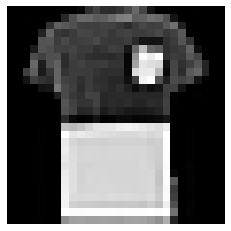

Etiqueta correcta: T-Shirt
----------------
Etiqueta     Probabilidad
T-Shirt      0.81709
Shirt        0.03289
Ankle Boot   0.01875
Bag          0.01875
Trouser      0.01875
Pullover     0.01875
Dress        0.01875
Coat         0.01875
Sandal       0.01875
Sneaker      0.01875


In [ ]:
example = 120
plot_img(test_data, example)
show_prediction(example)

## Comparamos con la CNN

In [ ]:
## Cargamos el txt con los datos del ipynb "CNN solamente"
data_CNN = np.loadtxt('data_CNN')

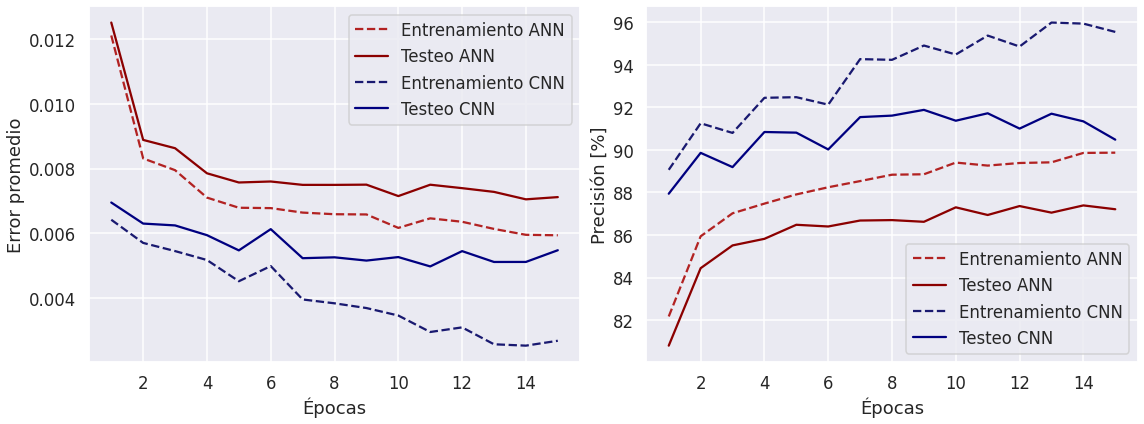

In [ ]:
X = range(1, len(train_losses)+1)

fig, axes = plt.subplots(figsize=(16, 6), ncols=2)
ax = axes[0]
ax.set_xlabel('Épocas')
ax.set_ylabel('Error promedio')
ax.plot(X, train_losses, label='Entrenamiento ANN', c='firebrick', linestyle='--')
ax.plot(X, test_losses, label='Testeo ANN', c='darkred')
ax.plot(X, data_CNN[0], label='Entrenamiento CNN', c='midnightblue', linestyle='--')
ax.plot(X, data_CNN[1], label='Testeo CNN', c='navy')
ax.legend()

ax = axes[1]
ax.set_xlabel('Épocas')
ax.set_ylabel('Precisión [%]')
ax.plot(X, train_acc_values, label='Entrenamiento ANN', c='firebrick', linestyle='--')
ax.plot(X, test_acc_values, label='Testeo ANN', c='darkred')
ax.plot(X, data_CNN[2], label='Entrenamiento CNN', c='midnightblue', linestyle='--')
ax.plot(X, data_CNN[3], label='Testeo CNN', c='navy')
ax.legend()

fig.tight_layout()
plt.savefig('Ambos-15_epocas.pdf', dpi=600, format='pdf')
plt.show()